# Stern and Gerlach simulation

It was discovered experimentally,[in 1922 by Stern and Gerlach](https://www.feynmanlectures.caltech.edu/II_35.html#Ch35-S2) (SG), that the spin of an electron along any direction is quantised, taking values of either $\hbar/2$ or $-\hbar/2$. The experiment involved firing silver atoms into an inhomogeneous magnetic field and observing a splitting of the beam in the direction of the field inhomogeneity.

Since then, people have described an idealised system of many SG systems in parallel that are capable of splitting apart and recombining the particle beams together (often called a Stern-Gerlach interferometer) to create interference effects that are commonly discussed in the two slit experiment (see e.g. the [Feynman lectures](https://www.feynmanlectures.caltech.edu/III_05.html#Ch5-S4)). 

To my surprise, it is only [very recently](https://arxiv.org/abs/1801.02708) that Stern-Gerlach interferometer experiments are being considered practical enough to implement and yet they are used frequently as a pedagogical example. It is therefore worth first developing an intuition for what one might expect from such SG interferometer experiments using only classical physics. That is the purpose of this notebook.

## Libraries

In [2]:
# need this to use the cross product later
using LinearAlgebra 

# using Plots http://docs.juliaplots.org/latest/install/
# https://gist.github.com/gizmaa/7214002 - examples uing PyPlot in Julia
using PyPlot

## Physical constants

In [3]:
# The g-factor https://en.wikipedia.org/wiki/G-factor_(physics)
g=2

# Bohn magneton
mu_B = 9.27400968e-24;

# electron charge
e = 1.602176634e-19

# electron mass (not needed but I have it here in case I need it later)
m_e = 9.1093837015e-31

# magnetic moment of the electron (ignoring g-factor corrections for now, i.e. g=2)
mu_e =  mu_B

# mass of silver atom
m_Ag = 107.9*1.66053906660e-27

# gyromagnetic ratio https://en.wikipedia.org/wiki/Gyromagnetic_ratio
gyro =  g*e/(2.0*m_Ag)

# magnetic moment of silver (same as a singleelectron because Ag has 1 electron in outer shell)
mu_Ag =  mu_e;

## Experimental set-up
A 2009 paper by França on "[The Stern–Gerlach Phenomenon According to Classical Electrodynamics](https://link.springer.com/article/10.1007/s10701-009-9338-1)" describes a lot of the set-up and parameters, e.g.

![Stern Gerlach setup](SG-setup.png)

An approximation for the magnetic field inside the electromagnet (length 3.5cm) is described by França's Eq 23:

$$
H = (-\beta x, 0, B_0 + \beta z)
$$

with $ \beta = 1800$ explicitly stated at the bottom of page 1186 and $B_0$ inferred from França's Fig 3 and checked in Fig. 5 of [Rabi's original paper](https://link.springer.com/article/10.1007/BF01339837).

In [4]:
# max B field inside the electromagnet
B0 = 1.4

# x and z B field gradient inside the electromagnet
gradB0 = 1800

# electromagnet dimesion in y
# note, I cannot find dimensions for x and z
machine_dim_y = 0.035;

To start with, we'll simulate a particle moving through the electromagnet only and deal with what happens at the magnet entrance later on.

Let's explore the B field given França's parameters.

In [87]:
function B(r)
    B = zeros(3)
    B[1] = -gradB0*r[1]
    B[3] = B0 + gradB0*r[3]
    return B
end;

We can visualise at the strength of B in the x,z plane using a contour plot.

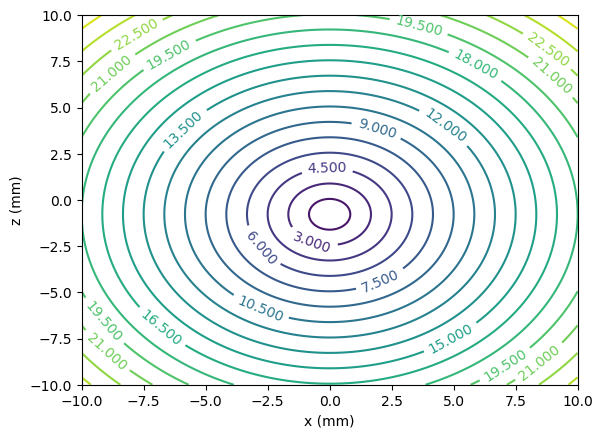

In [88]:
r = [[i,0,j] for i=-0.01:0.0001:0.01, j=-0.01:0.0001:0.01];
x = [x for (x,y,z) in r]
z = [z for (x,y,z) in r]
con = contour(x.*1000, z.*1000, norm.(B.(r)), levels=20)
xlabel("x (mm)")
ylabel("z (mm)")
clabel(con, inline=1, fontsize=10);

This field is very strong! To get a sense of what equipment generates these fields, below are figures taken  from the book `An Introduction to Quantum Physics` by French. This book is referenced in the França paper as a "modern" SG experiment.

![Modern Stern Gerlach setup 1](SG-french-01.png)

![Modern Stern Gerlach setup 2](SG-french-02.png)

## Equations of motion for a magnetic moment in a B field

If we consider a infinitesimal current loop, then the magnetic moment $\mu$ is:

$$
\mu = IA
$$

where $I$ is the current of the loop and $A$ is its area. The force on the loop is:

$$
\nabla(\mu\cdot B)
$$

and the torque is:

$$
\tau = \mu \times B
$$

cf. [wikipedia](https://en.wikipedia.org/wiki/Magnetic_moment#Effects_of_an_external_magnetic_field).

Recalling that:
1. a current loop has [angular momentum](https://en.wikipedia.org/wiki/Magnetic_moment#Relation_to_angular_momentum) $L=\mu/\gamma$ where $\gamma$ is the gyromagnetic ratio
2. the magnetic moment is not a function of position

we can write some equations of motion:

$$
\frac{dv}{dt} = \frac{1}{m}\mu\nabla B
$$

$$
\frac{d\mu}{dt} = \gamma \mu\times B
$$

where $\nabla B$ is the [gradient of the vector]( https://en.wikipedia.org/wiki/Gradient#Gradient_of_a_vector) B (i.e. a tensor) with components $\nabla B_{ij} = \partial B_i / \partial x _i$ which we can calculate using the function below.

In [95]:
function gradB(r)
    gradB = zeros(3,3)
    gradB[3,3] = gradB0
    gradB[1,1] = -gradB0
    return gradB
end;

From the equations of motion above we can expect:
1. the magnetic moment to move in the direction of gradients in the field
2. the orientation of the magnetic moment will precess about the direction of the magnetic field (see [Larmor precession](https://en.wikipedia.org/wiki/Larmor_precession))

## Set-up initial values for the simulation

We'll start the particles off with velocity only in the y direction at $v_0 = 600 \ m/s$ (see end of page 1181 of França article).

We'll initialise a random orientation of the magnetic moment using a spherical coordinate system:

$$ \mu = [\sin(\theta)\cos(\phi), \ \sin(\theta)\sin(\phi), \ \cos(\theta)]\mu_{Ag} $$

where $\theta$ and $\phi$ are the [spherical angle coordiantes](https://en.wikipedia.org/wiki/Spherical_coordinate_system#Cartesian_coordinates) corresponding to the ISO convention. In order to ensure a uniform distribution we must choose

$$
\theta = \arccos(2\times rand()-1) \\
\phi = 2\pi\times rand()
$$

as dicussed [here](https://math.stackexchange.com/a/1586583).

Because we expect some precessional motion, we should choose a time-step that resolves it. The [Larmor frequency](https://en.wikipedia.org/wiki/Larmor_precession#Larmor_frequency) $\omega = \gamma B$ is a good guide for this. We therefore need a timestep $\Delta t < 2\pi/\omega$:



In [8]:
2*pi/(gyro * B0)

5.018939737048401e-6

In [115]:
v0 = 600.0
v = [0,v0,0]
r = [0,0,0]

theta = acos(2*rand()-1)
phi = rand()*2*pi
mu = [sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta)]*mu_Ag

dt = 1.0e-7
t_max = machine_dim_y/v0
times = collect(0:dt:t_max)


r_save = zeros(length(times),3)
mu_save = zeros(length(times),3);

## Solving the equations of motion

To numerically solve equations of motion:

$$
\frac{dv}{dt} = \frac{1}{m}\mu\nabla B
$$

$$
\frac{d\mu}{dt} = \gamma \mu\times B
$$

I have employed an algorithm that's a hybrid of [leapfrog](https://en.wikipedia.org/wiki/Leapfrog_integration) and the [Boris method](https://www.particleincell.com/2011/vxb-rotation/).

In [116]:
for (i,t) in enumerate(times)
    
    r_save[i,:] = r
    mu_save[i,:] = mu
    
    # leapfrog kick
    v += (0.5*dt*(mu'*gradB(r))/m_Ag)'
    
    # Boris
    Br = B(r)
    s = 2.0/(1+(norm(Br)*gyro*dt*0.5)^2)
    mu_prime = mu + 0.5*dt*gyro*cross(mu,Br)
    mu += 0.5*dt*gyro*s*cross(mu_prime,Br)
    
    # leapfrog drift
    r += dt*v
    
    # leapfrog kick
    v += (0.5*dt*(mu'*gradB(r))/m_Ag)'
    
end

## Visualise the single particle results

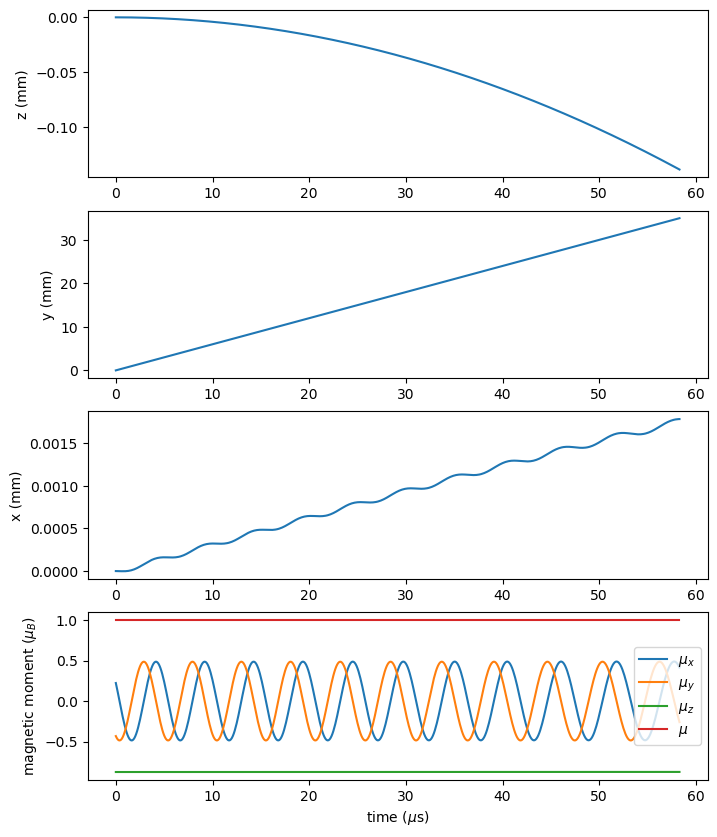

In [117]:
# In case we simulate lots of points and we don't want to plot them all because of memory,
# we can plot every 'n' points
n = 1
times_plot = times[1:n:end]./1e-6
r_save_plot = r_save[1:n:end,:]./1e-3
mu_save_plot = mu_save[1:n:end,:]./mu_B;
mu_norm_plot = [norm(mu_save_plot[i,:]) for i=1:size(mu_save_plot,1)]

figure(figsize=(8,10))

subplot(411)
plot(times_plot,(r_save_plot[:,3]), label="z");
ylabel("z (mm)")

subplot(412)
plot(times_plot,(r_save_plot[:,2]), label="y");
ylabel("y (mm)")

subplot(413)
plot(times_plot,(r_save_plot[:,1]), label="x");
ylabel("x (mm)")

subplot(414)
plot(times_plot,mu_save_plot[:,1], label=L"$\mu_x$")
plot(times_plot,mu_save_plot[:,2], label=L"$\mu_y$")
plot(times_plot,mu_save_plot[:,3], label=L"$\mu_z$")
plot(times_plot,mu_norm_plot, label=L"$\mu$")
xlabel(L"time ($\mu$s)")
ylabel(L"magnetic moment ($\mu_B$)")
legend(loc="right");

Because we initialised the magnetic moment at $x=0$, where $B_x=0$, the precession started around the z direction and so we see an oscillation of the $\mu_x$ and $\mu_y$. Because the $\mu_x$ oscillates, the force from the gradient of B in x also oscillates which creates the ripple in the x position.

## Simulating many particles

There are many things we can change about the initial conditions when simulating many particles, we can create a distribution of positions, of speeds, of magnetic moments etc. Let's begin with creating a distribution of magnetic moments. This simply means running the code above many times, picking a different random $\mu$ every time.

Because most of the interest in the SG experiment is in the final z distribution of the particles after they have gone through the magnet, we'll store the final z position and visualise how they are distributed. 

In [120]:
# number of particles
np = 1000

# place to store the final z-position
zs = zeros(np)

for p in 1:np
    
    v = [0,v0,0]
    r = [0,0,0]
    theta = acos(2*rand()-1)
    phi = rand()*2*pi
    mu = [sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta)]*mu_Ag
    

    muz_init[p] = mu[3]


    for (i,t) in enumerate(times)

        # leapfrog kick
        v += (0.5*dt*(mu'*gradB(r))/m_Ag)'

        # Boris
        Br = B(r)
        s = 2.0/(1+(norm(Br)*gyro*dt*0.5)^2)
        mu_prime = mu + 0.5*dt*gyro*cross(mu,Br)
        mu += 0.5*dt*gyro*s*cross(mu_prime,Br)

        # leapfrog drift
        r += dt*v

        # leapfrog kick
        v += (0.5*dt*(mu'*gradB(r))/m_Ag)'

    end
    
    zs[p] = r[3]

end

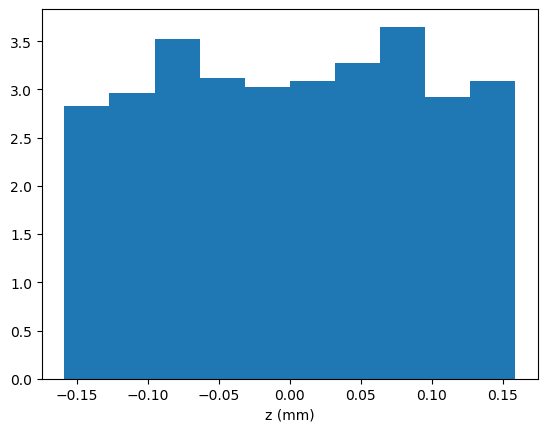

In [123]:
hist(zs/1e-3, normed=true);
xlabel("z (mm)");

Now let's initialise many different initial conditions and see what $z$ we end up with.

In [117]:
np = 1000
zs = zeros(np)
ys = zeros(np)
mus = zeros(np)
muz_init = zeros(np)

for p in 1:np
    
    # https://mathworld.wolfram.com/SphericalCoordinates.html
    # https://math.stackexchange.com/a/1586583
    theta = acos(2*rand()-1)
    phi = rand()*2*pi
    mu = [mu_e*sin(theta)*cos(phi), mu_e*sin(phi)*sin(theta), mu_e*cos(theta)]
    r = [0,-0.01,0]
    v = [0,v0,0]
    muz_init[p] = mu[3]


    for (i,t) in enumerate(times)

        v += (0.5*dt*(mu'*gradB(r))/m_Ag)'
        Br = B(r)
        s = 2.0/(1+(norm(Br)*gyro*dt*0.5)^2)
        mu_prime = mu + 0.5*dt*gyro*cross(mu,Br)
        mu += 0.5*dt*gyro*s*cross(mu_prime,Br)
        r += dt*v
        v += (0.5*dt*(mu'*gradB(r))/m_Ag)'
    end
    
    zs[p] = r[3]
    ys[p] = r[2]
    mus[p] = mu[3]
end

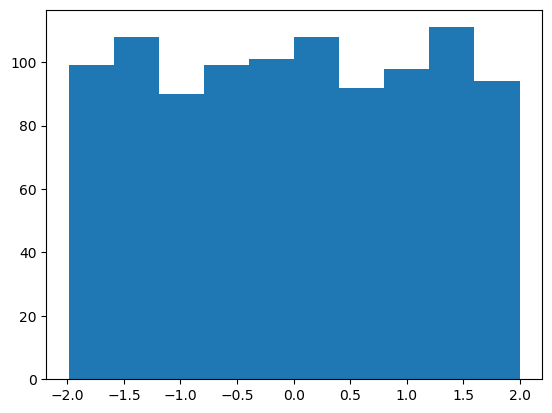

In [121]:
hist(muz_init./mu_B);

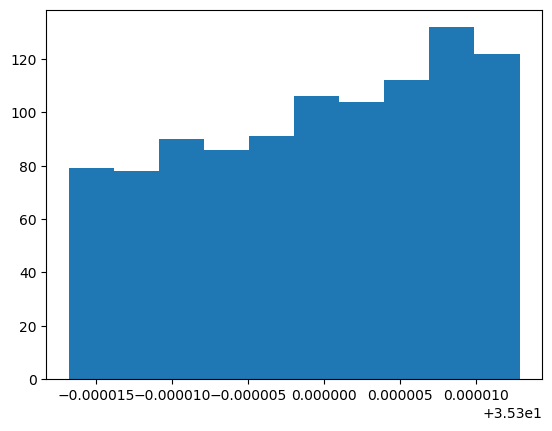

In [119]:
hist(ys./1e-3);

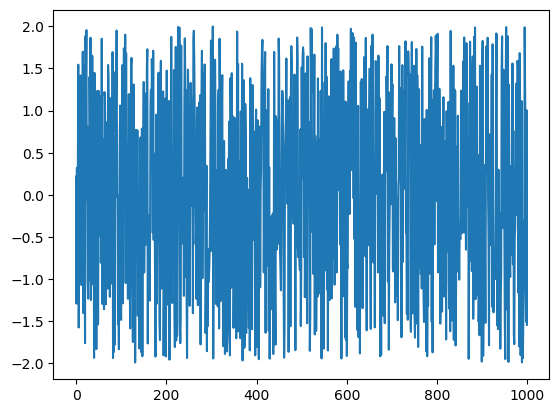

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14fe8d190>

In [120]:
plot(mus./mu_B)

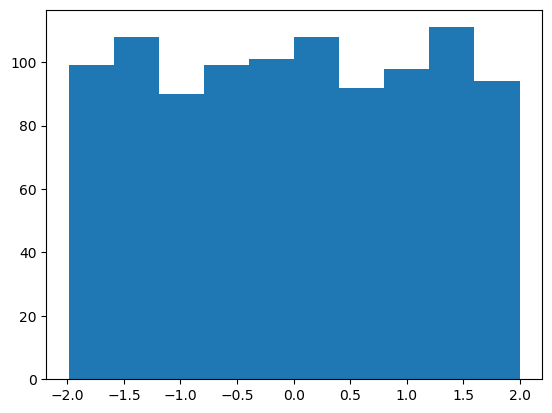

([99.0, 108.0, 90.0, 99.0, 101.0, 108.0, 92.0, 98.0, 111.0, 94.0], [-1.9884675496824138, -1.5898930022808728, -1.191318454879332, -0.7927439074777913, -0.39416936007625036, 0.004405187325290605, 0.40297973472683113, 0.8015542821283721, 1.200128829529913, 1.598703376931454, 1.9972779243329948], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x14f7a7f50>, PyObject <matplotlib.patches.Rectangle object at 0x14f7a7cd0>, PyObject <matplotlib.patches.Rectangle object at 0x14ff8fb50>, PyObject <matplotlib.patches.Rectangle object at 0x14f80d950>, PyObject <matplotlib.patches.Rectangle object at 0x14f80d750>, PyObject <matplotlib.patches.Rectangle object at 0x14f805290>, PyObject <matplotlib.patches.Rectangle object at 0x14f80de50>, PyObject <matplotlib.patches.Rectangle object at 0x14f805850>, PyObject <matplotlib.patches.Rectangle object at 0x14f80dcd0>, PyObject <matplotlib.patches.Rectangle object at 0x14f80dad0>])

In [122]:
hist(mus./mu_B)

In [ ]:
function B(r)
    B = zeros(3)
    B[1] = -gradB0*r[1]
#     B[3] = B0 + gradB0*r[3]
    B[3] = B0.*(0.5.*tanh.(800.0.*r[3].+2.0).+0.5);
    return B
end;

In [ ]:
# https://en.wikipedia.org/wiki/Gradient#Gradient_of_a_vector
function gradB(r)
    gradB = zeros(3,3)
    gradB[3,3] = gradB0
    gradB[3,2] = B0.*0.5.*sech.(800.0.*r[3].+2.0).^2
    ## gradB[1,1] = -gradB0
    return gradB
end;